[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drscotthawley/DLAIE/blob/main/Lessons/16_VAE.ipynb)

# Let's Make a Variational AutoEncoder (VAE)

Essentially:
* we force the Decoder to decode points in latent space *nearby* to the point corresponding to the encoded image
* we 'srunch' the latent space so it looks like a gaussian

In [1]:
# we'll use pytorch lightning as an alternative to raw pytorch
!pip install -qq lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 13.0 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn, optim, utils
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torchvision
import matplotlib.pyplot as plt
import lightning as L

## Setup Dataset
Yep, good 'ol MNIST. It's small and easy and you can do it on a CPU. Let's keep everything super-simple at first: black & white images.

In [3]:
train_ds = MNIST(root='./data', train=True,  download=True, transform=ToTensor())
test_ds  = MNIST(root='./data', train=False, download=True, transform=ToTensor())
print(f"Data set lengths: train: {len(train_ds)}, test: {len(test_ds)}")

100%|██████████| 9912422/9912422 [00:00<00:00, 94381071.09it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 3163720.49it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 48749807.19it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18388541.28it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Data set lengths: train: 60000, test: 10000


Inspect it a bit..

y (target) = 5 
x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0


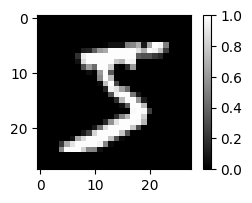

In [4]:
x, y = train_ds[0]   # pick an element
print(f"y (target) = {y} ")

def show_xs(xs, show_stats=True):
    "A little utility we'll call again & again to show one or more images"
    if type(xs) is not list: xs = list(xs)
    ncols = len(xs)
    fig, axs = plt.subplots(figsize=(3*ncols,2), ncols=ncols, squeeze=False)
    ax = axs.ravel()
    for col, x in enumerate(xs):
        if len(x.shape)>2: x = x[0] # remove any batch dimension
        if show_stats:
            if ncols > 1: print(f"col {col}: ",end="")
            print(f"x.shape = {tuple(x.shape)}, min(x) = {torch.min(x)}, max(x) = {torch.max(x)}")
        digit = ax[col].imshow(x.detach().cpu().numpy(), cmap='gray')
        fig.colorbar(digit, ax=ax[col])
    plt.show()

show_xs([x])

Define dataloaders

In [5]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=4, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=4, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Make an (Regular) AE Model

First we'll try a regular autoencoder. Then we'll make it "variational"

In [11]:
latent_dim = 3

n_hid = [256, 64, latent_dim]

act = nn.LeakyReLU

encoder = nn.Sequential(
                nn.Linear(28 * 28, n_hid[0]),
                act(),
                nn.Linear(n_hid[0], n_hid[1]),
                act(),
                nn.Linear(n_hid[-2], latent_dim))

decoder = nn.Sequential(
                nn.Linear(latent_dim, n_hid[-2]),
                act(),
                nn.Linear(n_hid[1], n_hid[0]),
                act(),
                nn.Linear(n_hid[0], 28 * 28))

z =  tensor([[ 0.0877, -0.0914,  0.0437]], grad_fn=<AddmmBackward0>)
x.shape = (28, 28), min(x) = -0.2399991750717163, max(x) = 0.21236616373062134


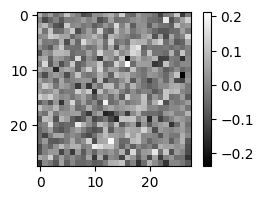

In [12]:
# test it
z = encoder(x.view(x.size(0), -1) )
print("z = ",z)
x_hat = decoder(z)
x_hat = x_hat.view(x.size(0), 28, -1)
show_xs(x_hat)

In [13]:
# instead of nn.Module, we use L.LightningModule
class AEModel(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return z, x_hat

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)  # flatten for linear layer
        z, x_hat = self.forward(x)
        loss = nn.functional.mse_loss(x_hat, x)
        self.log('loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

In [14]:
autoencoder = AEModel(encoder, decoder)

epochs = 4
trainer = L.Trainer(max_epochs=epochs, devices="auto")
trainer.fit(model=autoencoder, train_dataloaders=train_dl)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 217 K 
1 | decoder | Sequential | 218 K 
---------------------------------------
435 K     Trainable params
0         Non-trainable params
435 K     Total params
1.744     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=4` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


z =  tensor([[ 0.0877, -0.0914,  0.0437]], grad_fn=<AddmmBackward0>)
col 0: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0
col 1: x.shape = (28, 28), min(x) = -0.08663907647132874, max(x) = 1.011501431465149


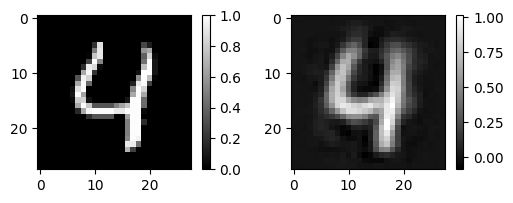

In [16]:
@torch.no_grad()
def test_inference(model, idx=None):
    "Another utility we'll use for running images through the (V)AE"
    if idx is None: idx = torch.randint( len(test_ds), (1,) )[0]
    x, y = test_ds[idx]
    x_hat = model.forward(x.view(x.size(0), -1))[-1]
    print("z = ",z)
    x_hat = x_hat.view(x.size(0), 28, -1)
    show_xs([x,x_hat])

idx = 4
test_inference(autoencoder, idx=idx)

## Now Let's Make it 'Varational'

In [17]:
# encoder now spits out mean and variance
vae_encoder = nn.Sequential(
                nn.Linear(28 * 28, n_hid[0]),
                act(),
                nn.Linear(n_hid[0], n_hid[1]),
                act(),
                nn.Linear(n_hid[-2], latent_dim*2)) # *2 b/c mu, log_var

# decoder same as before
decoder = nn.Sequential(
                nn.Linear(latent_dim, n_hid[-2]),
                act(),
                nn.Linear(n_hid[1], n_hid[0]),
                act(),
                nn.Linear(n_hid[0], 28 * 28))

In [18]:
# instead of nn.Module, we use L.LightningModule
class VAEModel(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparam_sample(self, mu, log_var):
        std = torch.exp(0.5*log_var).sqrt() # why the 0.5?
        noise = torch.randn_like(std)       # the "noise"
        return mu + std * noise

    def forward(self, x):
        z = self.encoder(x)
        i_half = z.shape[-1]//2
        mu, log_var = z[:,:i_half],  z[:,i_half:]
        z_hat = self.reparam_sample(mu, log_var)
        x_hat = self.decoder(z_hat)
        return z, mu, log_var, z_hat, x_hat

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)  # flatten for linear layer
        z, mu, log_var, z_hat, x_hat = self.forward(x)
        recon_loss = nn.functional.mse_loss(x_hat, x)
        scrunch_factor = 0.01     # weak but ok
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + kl_loss*scrunch_factor
        self.log('loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

In [19]:
vae = VAEModel(vae_encoder, decoder)

epochs = epochs*2
trainer = L.Trainer(max_epochs=epochs, devices="auto")
trainer.fit(model=vae, train_dataloaders=train_dl)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 217 K 
1 | decoder | Sequential | 218 K 
---------------------------------------
436 K     Trainable params
0         Non-trainable params
436 K     Total params
1.745     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=8` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=8` reached.


z =  tensor([[ 0.0877, -0.0914,  0.0437]], grad_fn=<AddmmBackward0>)
col 0: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0
col 1: x.shape = (28, 28), min(x) = -0.04795551300048828, max(x) = 0.9502869844436646


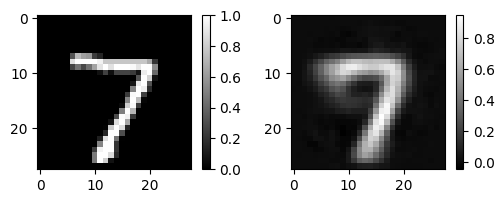

In [24]:
test_inference(vae, idx=idx)

Looks similar to the regular autoencoder, right?

Now let's try perturbing our input a bit

## Comparing the AE and VAE

Perturbing the regular autoencoder with strength = 30.0:


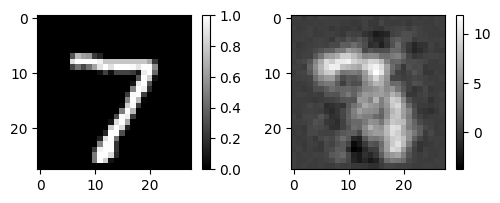

Perturbing the VAE with strength = 30.0:


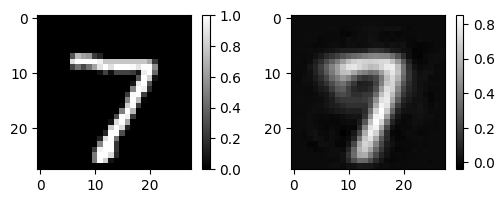

In [25]:
@torch.no_grad()
def infer_perturb(model, idx=None, strength=1.0):
    "Another utility we'll use for running images through the (V)AE"
    if idx is None: idx = torch.randint( len(test_ds), (1,) )[0]
    x, y = test_ds[idx]
    z = model.encoder(x.view(x.size(0), -1))
    if z.shape[-1] > latent_dim: z = z[:,:latent_dim] # if VAE, just use the mean values
    z_hat = z + strength*torch.randn_like(z)
    x_hat = model.decoder(z_hat)
    x_hat = x_hat.view(x.size(0), 28, -1)
    show_xs([x,x_hat], show_stats=False)

idx=0
strength = 30.0
print(f"Perturbing the regular autoencoder with strength = {strength}:")
infer_perturb(autoencoder, idx=idx, strength=strength)
print(f"Perturbing the VAE with strength = {strength}:")
infer_perturb(vae, idx=idx, strength=1.0)

Depending on the random values you get, perturbations may cause the regular AE output to look like not-a-number, whereas the VAE output is probably more stable.

Note that typically the output of the regular AE extends way outside the [0,1] intensity bounds.

### TODO: Add interpolation.